In [1]:
from devito import *
from examples.seismic.source import WaveletSource, TimeAxis
from examples.seismic import plot_image
import numpy as np

from sympy import init_printing, latex
init_printing(use_latex=True)

In [2]:
# Initial grid: 1km x 1km, with spacing 100m
extent = (2000., 2000.)
shape = (81, 81)
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = Grid(extent=extent, shape=shape, dimensions=(x, z))

In [3]:
class DGaussSource(WaveletSource):
    
    def wavelet(self, f0, t):
        a = 0.004
        return -2.*a*(t - 1./f0) * np.exp(-a * (t - 1./f0)**2)

# Timestep size from Eq. 7 with V_p=6000. and dx=100
t0, tn = 0., 200.
dt = 1e2*(1. / np.sqrt(2.)) / 60.
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = DGaussSource(name='src', grid=grid, f0=0.01, time_range=time_range)
src.coordinates.data[:] = [1000., 1000.]

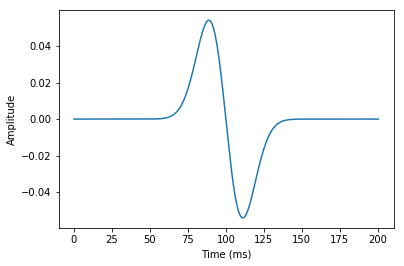

In [4]:
#NBVAL_SKIP

src.show()

In [5]:
# Now we create the velocity and pressure fields
p = TimeFunction(name='p', grid=grid, staggered=NODE, space_order=2, time_order=1)
v = VectorTimeFunction(name='v', grid=grid, space_order=2, time_order=1)

In [6]:
from devito.finite_differences.operators import div, grad
t = grid.stepping_dim
time = grid.time_dim

# We need some initial conditions
V_p = 4.0
#V_s = 1.0
density = 3.

dx = 100.
rox = 1/density * dt
roz = 1/density * dt
l2m = V_p*V_p*density * dt

c1 = 9.0/8.0;
c2 = -1.0/24.0;

# The source injection term
src_p = src.inject(field=p.forward, expr=src)

# 2nd order acoustic according to fdelmoc
u_v_2 = Eq(v.forward, v + rox * grad(p))
u_p_2 = Eq(p.forward, p + l2m * div(v.forward))

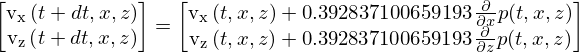

In [7]:
u_v_2

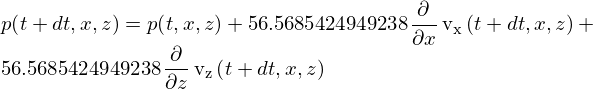

In [8]:
u_p_2

In [9]:
op_2 = Operator([u_v_2, u_p_2] + src_p)

In [10]:
#NBVAL_IGNORE_OUTPUT

# Propagate the source
op_2(time=src.time_range.num-1)

Operator `Kernel` run in 0.73 s


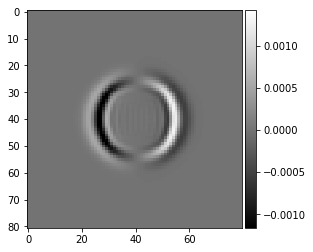

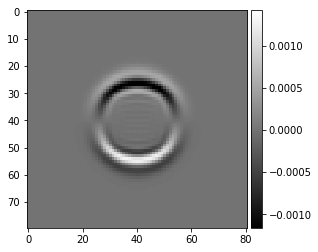

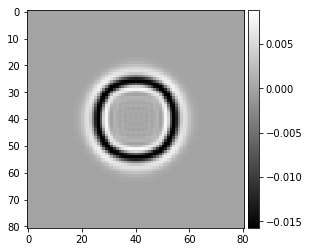

In [11]:
#NBVAL_SKIP

# Let's see what we got....
plot_image(v[0].data[0])
plot_image(v[1].data[0])
plot_image(p.data[0])

In [12]:
norm_p = norm(p)
assert np.isclose(norm_p, .35098, atol=1e-4, rtol=0)

In [13]:
#NBVAL_IGNORE_OUTPUT

# # 4th order acoustic according to fdelmoc
# # Now we create the velocity and pressure fields
p4 = TimeFunction(name='p', grid=grid, staggered=NODE, space_order=4, time_order=1)
v4 = VectorTimeFunction(name='v', grid=grid, space_order=4, time_order=1)
u_v_4 = Eq(v4.forward, v4 + rox * grad(p4))
u_p_4 = Eq(p4.forward, p4 + l2m * div(v4.forward))

In [14]:
op_4 = Operator([u_v_4, u_p_4] + src_p)
# Propagate the source
op_4(time=src.time_range.num-1)

Operator `Kernel` run in 2.87 s


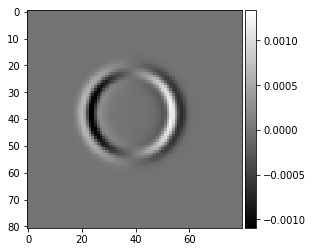

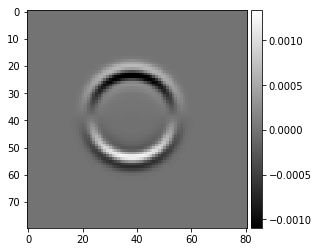

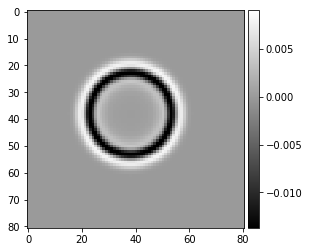

In [15]:
#NBVAL_SKIP

# Let's see what we got....
plot_image(v4[0].data[-1])
plot_image(v4[1].data[-1])
plot_image(p4.data[-1])

In [16]:
norm_p = norm(p)
assert np.isclose(norm_p, .35098, atol=1e-4, rtol=0)